In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [25]:
def f(x):
    return 3*x**2 - 4*x + 5

In [26]:
f(3.0)

20.0

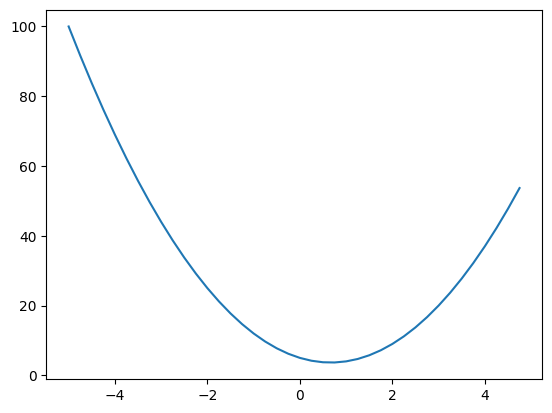

In [27]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [28]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [29]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [30]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [35]:
from platform import node


class Value:
    def __init__ (self, data, children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(children)
        self._op = _op 
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})" 
    
    def __add__(self, other,):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), _op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):  # <<< this is for right addition, when the left operand does not support addition with the right operand, Python will call the right operand's __radd__ method
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, children=(self,), _op=f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad # derivative of x^n is n*x^(n-1)
        out._backward = _backward
        return out
    
    def __rmul__(self, other):  # <<< this is for right multiplication, when the left operand does not support multiplication with the right operand, Python will call the right operand's __rmul__ method
        return self * other
    
    def __truediv__(self, other):  # <<< this is for division, we can implement division as multiplication with the reciprocal
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1 # <<< this is for division, we can implement division as multiplication with the reciprocal
    # a / b => a * 1/b => a * b**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad # derivative of tanh is 1 - tanh^2
        out._backward = _backward
        return out  
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad # derivative of exp is exp
        out._backward = _backward
        return out
    
    def backward(self):
        # Topological graph of the neuron
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0 # the base case of backprop, the gradient of the output node is 1.0
        for node1 in reversed(topo):
            node1._backward()

    def relu(self):
    #"""ReLU activation: max(0, x) with proper backprop"""
        x = self.data
        out = Value(max(0, x), (self,), 'ReLU')

        def _backward():
            self.grad += (1.0 if x > 0 else 0.0) * out.grad  # derivative of ReLU
            
        out._backward = _backward
        return out

    
# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a*b; e.label='e'
# d = e + c; d.label='d'
# #a + b #a.__add__(b) internal call in Python
# f = Value(-2.0, label='f')
# L = d * f; L.label='L'
# L

In [36]:
a = Value(2.0)
b = Value(4.0)
b/a
a-b
#a.exp()

Value(data=-2.0)

In [37]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it

    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 


    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [38]:
draw_dot(L)

NameError: name 'L' is not defined

In [39]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad # leaf nodes we have control over
f.data += 0.01 * f.grad 

e = a * b
d = e + c
L = d * f

print(L.data)

AttributeError: 'float' object has no attribute 'data'

In [40]:
L.grad = 1.0
f.grad = 4
d.grad = -2
c.grad = -2
e.grad = -2

a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

NameError: name 'L' is not defined

In [41]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L=d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    # a.data += h
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    # c.data += h
    e = a*b; e.label='e'
    # e.data += h
    d = e + c; d.label='d'
    # d.data += h
    f = Value(-2.0, label='f')
    L=d * f; L.label = 'L'
    L2 = L.data



    print((L2-L1)/h)
lol()

-3.9999999999995595


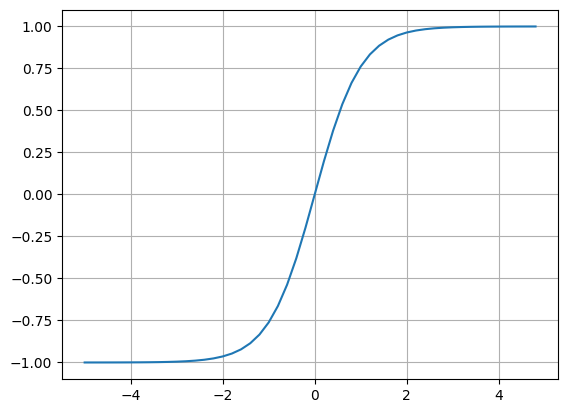

In [42]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [43]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

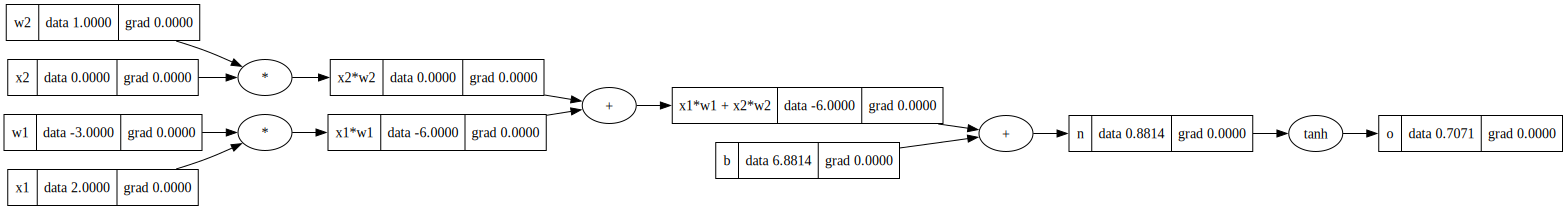

In [44]:
draw_dot(o)

In [45]:
o.backward()

In [46]:
# Topological graph of the neuron
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [47]:
#auto backpropagation using the chain rule and local gradients defined functions in the Value class
o.grad = 1.0 # last node gradient is always 1.0
o._backward() # this will call the backward function defined in the tanh function of the Value class and will update the gradients of n, x1w1x2w2, b, x1w1, x2w2, x1, w1, x2, w2 accordingly

In [48]:
n._backward() # this will call the backward function defined in the addition function of the Value class and will update the gradients of x1w1, x2w2, b accordingly

In [49]:
b._backward() # b is a leaf node and has no children, so its backward function does nothing

In [50]:
x1w1x2w2._backward() # this will call the backward function defined in the addition function of the Value class and will update the gradients of x1w1, x2w2 accordingly

In [51]:
x1w1._backward() # this will call the backward function defined in the multiplication function of the Value class and will update the gradients of x1, w1 accordingly
x2w2._backward() # this will call the backward function defined in the multiplication function of the Value class and will update the gradients of x2, w2 accordingly

In [52]:
#manually setting gradients for each node 
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x1w1x2w2.grad = 0.5 # due to + sign between b, x1w1x2w2 and n gradient distributed equally to both b and x1w1x2w2 as 0.5 

b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
n.grad = 0.5
o.grad = 1.0 #last node gradient is always 1.0
# o = tanh(n)
# do a local gradient step on n
# do / dn = 1 - tanh(n)**2
n.grad = (1 - o.data**2) * o.grad

print(n.grad)

0.4999999999999999


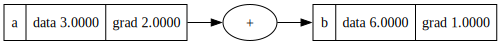

In [53]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

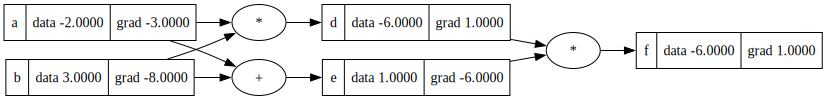

In [54]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a*b; d.label = 'd'
e = a+b; e.label = 'e'
f = d*e; f.label = 'f'
f.backward()
draw_dot(f)


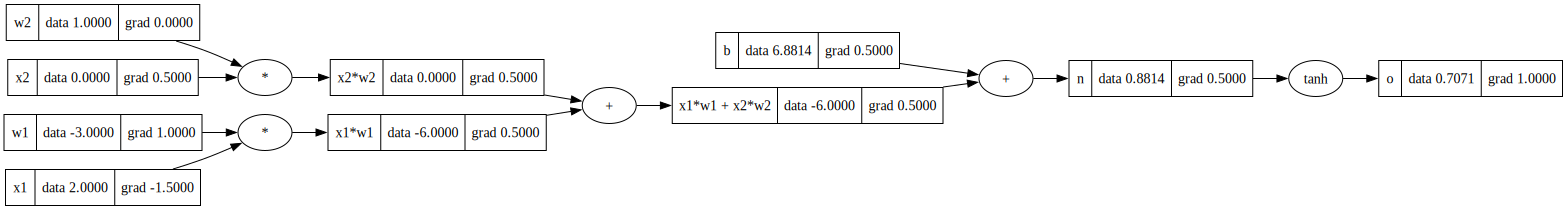

In [55]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

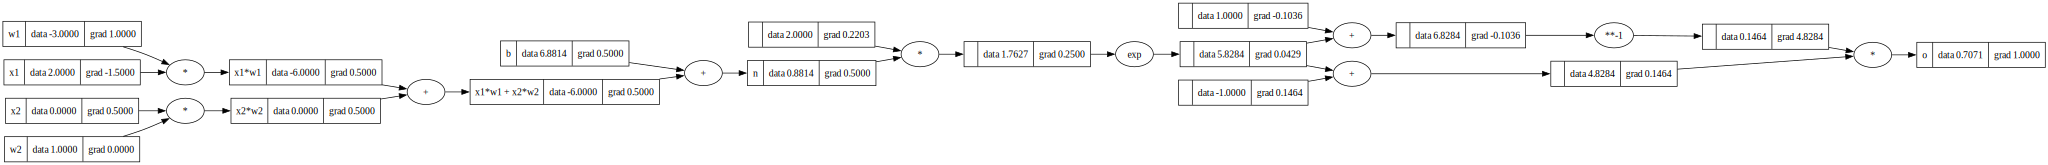

In [56]:
# inputs x1,x2 : tanh(x1*w1 + x2*w2 + b)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
#--- tanh manual ---#
e = (2*n).exp()
o = (e -1) / (e + 1)
o.label='o'

o.backward()
draw_dot(o)

In [57]:
import torch

x1 = torch.Tensor([2.0]).double()                       ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                       ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()         ; b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.item())

o.backward()
print("------------")
print("X1: ",x1.grad.item())
print("X2: ",x2.grad.item())
print("W1: ",w1.grad.item())
print("W2: ",w2.grad.item())

0.7071066904050358
------------
X1:  -1.5000003851533106
X2:  0.5000001283844369
W1:  1.0000002567688737
W2:  0.0


In [58]:
import random

In [59]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # compute the weighted sum of the inputs and weights
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # <<< this is for summing up the weighted inputs and bias, we can use the built-in sum function and pass the generator expression that computes the weighted inputs and bias as the first argument and the initial value of the sum as the second argument
        out = act.tanh() # <<< this is for applying the activation function to the weighted sum, we can use the tanh function defined in the Value class
        return out
    
    def parameters(self):
        return self.w + [self.b] # <<< this is for returning the parameters of the neuron, we can return the weights and bias as a list
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()] # <<< this is for returning the parameters of the layer, we can use a list comprehension to iterate over the neurons and their parameters and return a flat list of all parameters in the layer
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()] # <<< this is for returning the parameters of the MLP, we can use a list comprehension to iterate over the layers and their parameters and return a flat list of all parameters in the MLP

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0   #<<< this is for resetting the gradients of all parameters in the MLP to zero, we can iterate over all parameters and set their grad attribute to 0.0


In [60]:

x = [2.0, 3.0,-1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.9705823225963557)

In [61]:
len(n.parameters())

41

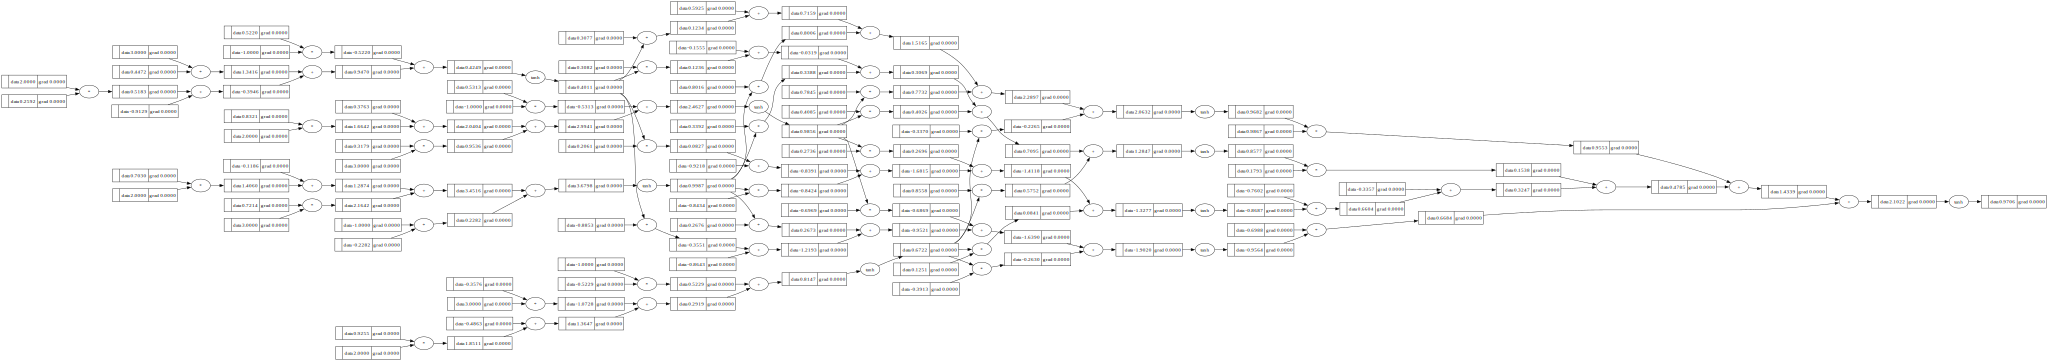

In [62]:
draw_dot(n(x))

In [63]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired outputs

In [64]:
for k in range(200):
    #forward pass
    # root mean squared error
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update parameters using gradient descent
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 7.664528092980599
1 7.5753852159918695
2 7.43403874234157
3 7.187990826285443
4 6.707020318311275
5 5.682062965530379
6 4.08107709151513
7 3.6147202759478825
8 3.3192917359994936
9 2.883717563315378
10 2.11387455146854
11 1.3952067659575433
12 0.9775165644380454
13 0.6924974124802978
14 0.5020606931351592
15 0.3773684570713968
16 0.29447233752010765
17 0.23743429553223155
18 0.19667595874401428
19 0.1665194768286856
20 0.143524024873457
21 0.12553353428598005
22 0.11114897716243285
23 0.09943228075793448
24 0.08973553763414657
25 0.08159930014167421
26 0.07469006711630406
27 0.0687606990315539
28 0.06362465686536983
29 0.05913881480981796
30 0.055191731716794756
31 0.05169548234444521
32 0.04857986149083289
33 0.04578820182040184
34 0.043274309353954446
35 0.04100018614761934
36 0.03893431599609119
37 0.037050358569851144
38 0.035326143735716964
39 0.033742889180445226
40 0.03228458601665418
41 0.03093751207655593
42 0.029689843209349538
43 0.02853134048216463
44 0.02745309666739828


In [65]:
ypred

[Value(data=0.9819303420269454),
 Value(data=-0.9724639406895172),
 Value(data=-0.9729935961857594),
 Value(data=0.960245458890953)]

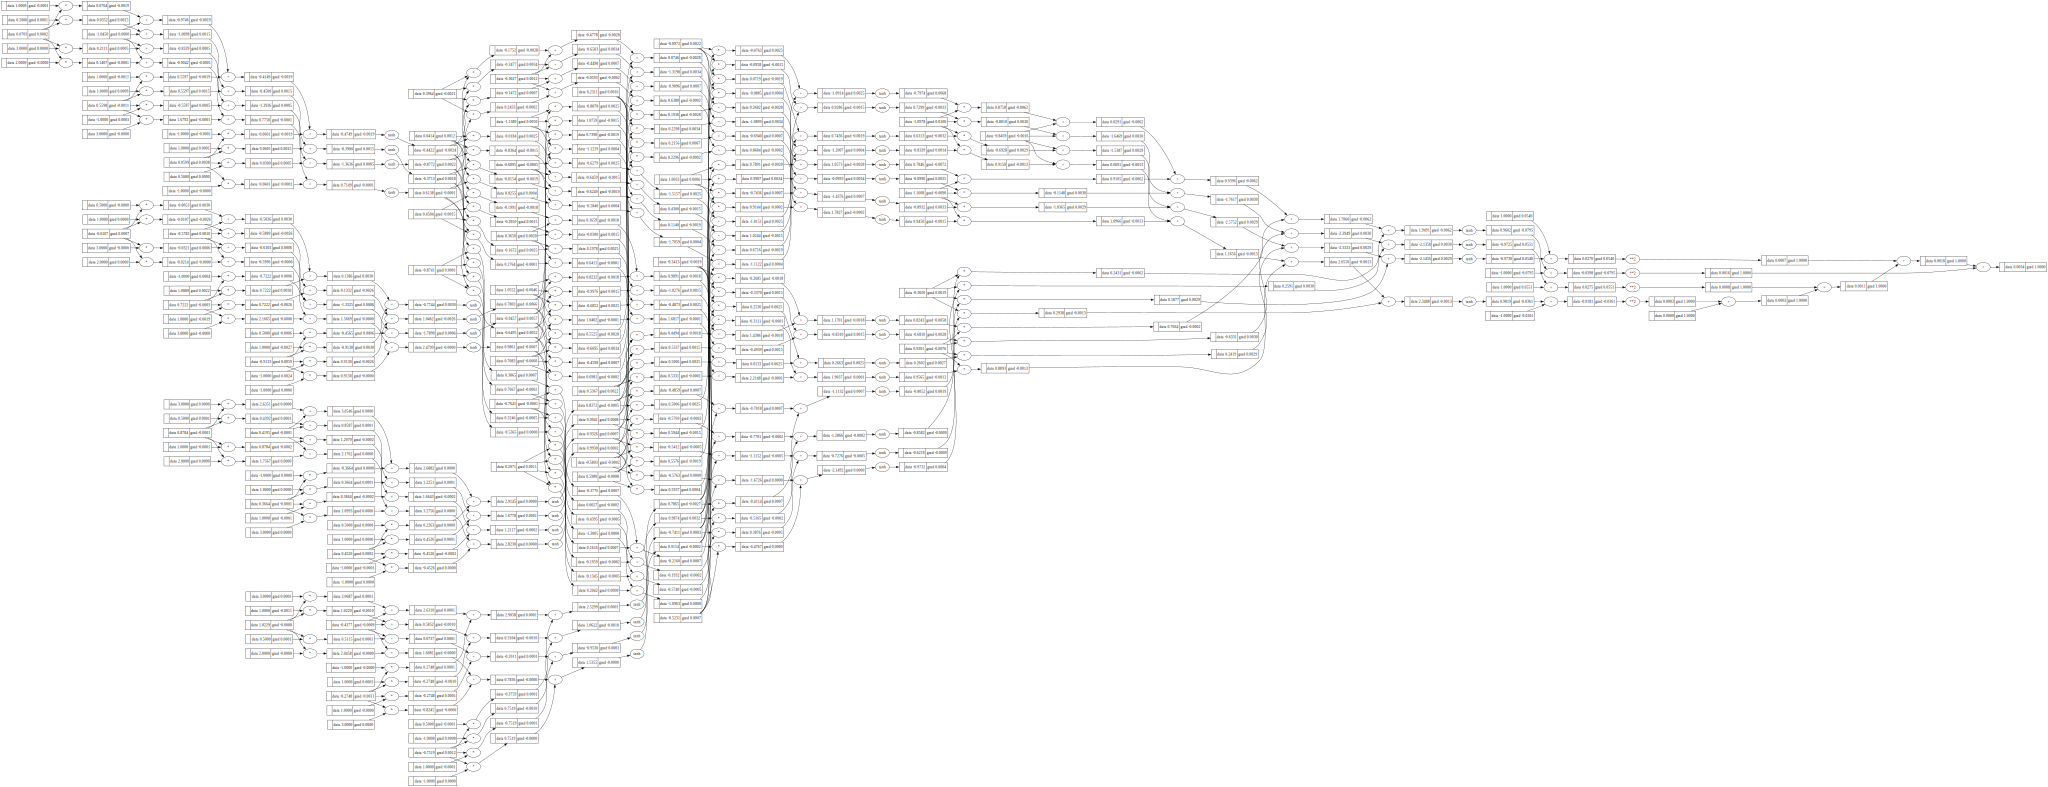

In [66]:
draw_dot(loss)

In [67]:
np.random.seed(1337)
random.seed(1337)

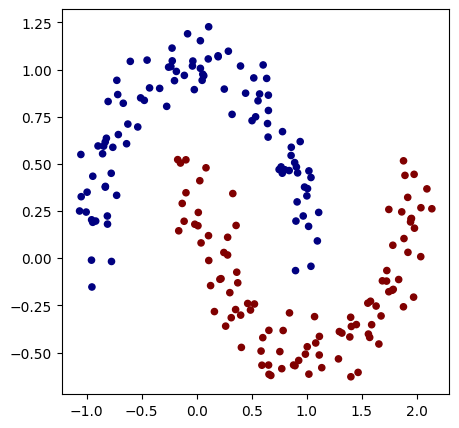

In [68]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=200, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [69]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


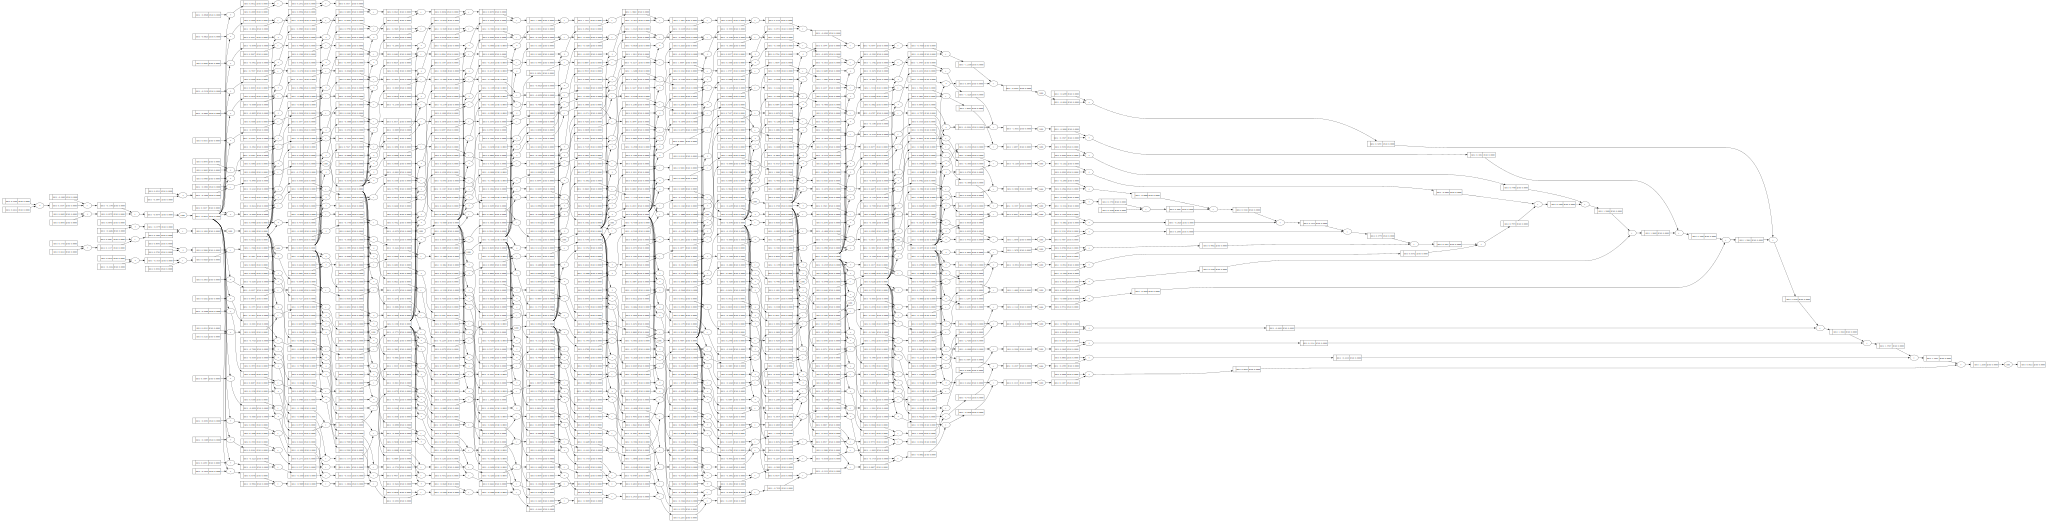

In [70]:
draw_dot(model(X[0]))

In [71]:
# loss function: computes training loss + accuracy
def loss(batch_size=None):
    
    # --- Mini-batch sampling (inline DataLoader) ---
    # If no batch size is given, use the full dataset
    if batch_size is None:
        Xb, yb = X, y
    else:
        # randomly shuffle indices and select a subset
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    # convert numeric inputs into Value objects for autodiff
    # each xrow becomes a list of Value nodes
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # --- Forward pass ---
    # run each input through the neural network
    # scores = model predictions
    scores = list(map(model, inputs))
    
    # --- SVM hinge loss (max-margin classification loss) ---
    # computes: max(0, 1 - y * score)
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    
    # average the loss across the batch
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # --- L2 regularization ---
    # penalizes large weights to prevent overfitting
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    
    # total objective = classification loss + regularization
    total_loss = data_loss + reg_loss
    
    # --- Accuracy calculation ---
    # check if predicted sign matches true label
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    
    # return both loss (for training) and accuracy (for monitoring)
    return total_loss, sum(accuracy) / len(accuracy)


# compute current loss and accuracy
total_loss, acc = loss()

# print training status
print(total_loss, acc)

Value(data=0.7858383265979401) 0.67


In [76]:
# optimization / training loop
for k in range(100):  # run 100 training steps (epochs)

    # ----- Forward pass -----
    # compute current loss value and accuracy using the model
    total_loss, acc = loss()

    # ----- Backward pass -----
    # reset all gradients to zero before computing new gradients
    model.zero_grad()

    # compute gradients via backpropagation
    # fills p.grad for every parameter in the model
    total_loss.backward()

    # ----- Parameter update (Stochastic Gradient Descent) -----
    # learning rate decays gradually over time
    learning_rate = 1.0 - 0.9*k/100

    # update each parameter using gradient descent rule:
    # new_weight = old_weight - learning_rate * gradient
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    # ----- Logging -----
    # print training progress every iteration
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.03446550928590414, accuracy 100.0%
step 1 loss 0.033899862692988086, accuracy 100.0%
step 2 loss 0.0333672877183412, accuracy 100.0%
step 3 loss 0.03286515450620639, accuracy 100.0%
step 4 loss 0.0323910962512548, accuracy 100.0%
step 5 loss 0.0319429785574188, accuracy 100.0%
step 6 loss 0.03151887173170961, accuracy 100.0%
step 7 loss 0.031117028380745145, accuracy 100.0%
step 8 loss 0.030735862371297582, accuracy 100.0%
step 9 loss 0.030373933714941098, accuracy 100.0%
step 10 loss 0.03002993237880683, accuracy 100.0%
step 11 loss 0.029702671007002593, accuracy 100.0%
step 12 loss 0.029391071876774436, accuracy 100.0%
step 13 loss 0.029094168874652916, accuracy 100.0%
step 14 loss 0.02881108882075599, accuracy 100.0%
step 15 loss 0.02854106721941012, accuracy 100.0%
step 16 loss 0.02828338353682805, accuracy 100.0%
step 17 loss 0.028037436456280953, accuracy 100.0%
step 18 loss 0.02780249900111712, accuracy 100.0%
step 19 loss 0.02757808138260881, accuracy 100.0%
step 

(-1.6284239638836362, 2.171576036116367)

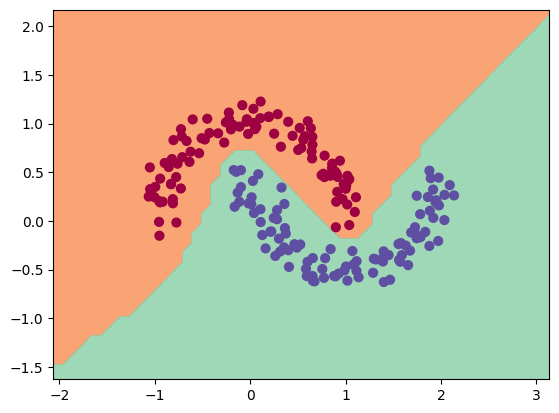

In [79]:
# ----- Visualize decision boundary -----

h = 0.10  # step size of the grid (smaller = smoother boundary)

# define plotting limits with some padding around dataset
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# create a 2D grid of points covering the input space
# xx and yy are matrices representing x and y coordinates
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

# flatten the grid into a list of coordinate pairs
# each row is a point (x, y)
Xmesh = np.c_[xx.ravel(), yy.ravel()]

# convert each point into Value objects for the neural net
inputs = [list(map(Value, xrow)) for xrow in Xmesh]

# run all grid points through the trained model
scores = list(map(model, inputs))

# classify predictions:
# True (class +1) if score > 0, else False (class -1)
Z = np.array([s.data > 0 for s in scores])

# reshape predictions back into grid shape
Z = Z.reshape(xx.shape)

# ----- Plotting -----

fig = plt.figure()

# color background regions based on predicted class
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

# overlay actual training data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

# set plot limits
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
